In [36]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact

# Breakfast Buffet Example


In [37]:
# Set seed for reproducibility
np.random.seed(10010)

foods = ["Pastry", "Granola", "Yogurt", "Potatoes", "Eggs"]
N_obs = 5000
probabilities = [0.1, 0.4, 0.4, 0.1] # make 2-3 items more common than the extremes
num_events = np.random.choice([1, 2, 3, 4], N_obs, p=probabilities)
print(pd.Series(num_events).value_counts().sort_index())


1     498
2    1973
3    1983
4     546
Name: count, dtype: int64


In [38]:
def one_event(length, data, sep='-'):
    prob = np.array([5, 4, 3, 2, 1]) / 15
    event = np.random.choice(data, length, p=prob, replace=True)
    return sep.join(event)

# Test the function
print(one_event(3, foods))
print(one_event(6, foods))


Granola-Granola-Granola
Potatoes-Potatoes-Pastry-Granola-Potatoes-Pastry


In [39]:
# Generate all event sequences
events = [one_event(length, foods) for length in num_events]
events_series = pd.Series(events)

# Calculate frequencies
events_freq = events_series.value_counts().reset_index()
events_freq.columns = ['path', 'count']

# Define the color palette and a dictionary to map food items to colors
breakfast_palette = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00']
color_map = {food: color for food, color in zip(foods, breakfast_palette)}


In [40]:
def build_buffet_sunburst_data(df):
    node_data = []
    added_nodes = set()

    for _, row in df.iterrows():
        path = row['path']
        value = row['count']

        nodes = path.split('-')

        for i in range(1, len(nodes) + 1):
            current_path = '-'.join(nodes[:i])
            parent_path = '-'.join(nodes[:i-1]) if i > 1 else ''

            if current_path not in added_nodes:
                # Add the color to the node data
                label = nodes[i-1]
                color = color_map.get(label, '#CCCCCC') # Default to grey if not in map
                node_data.append({
                    'id': current_path,
                    'parent': parent_path,
                    'label': label,
                    'value': 0, # Initialize intermediate node values to zero
                    'color': color
                })
                added_nodes.add(current_path)

            if i == len(nodes):
                for node in node_data:
                    if node['id'] == current_path:
                        node['value'] = value
                        break

    return pd.DataFrame(node_data)

sunburst_df = build_buffet_sunburst_data(events_freq)

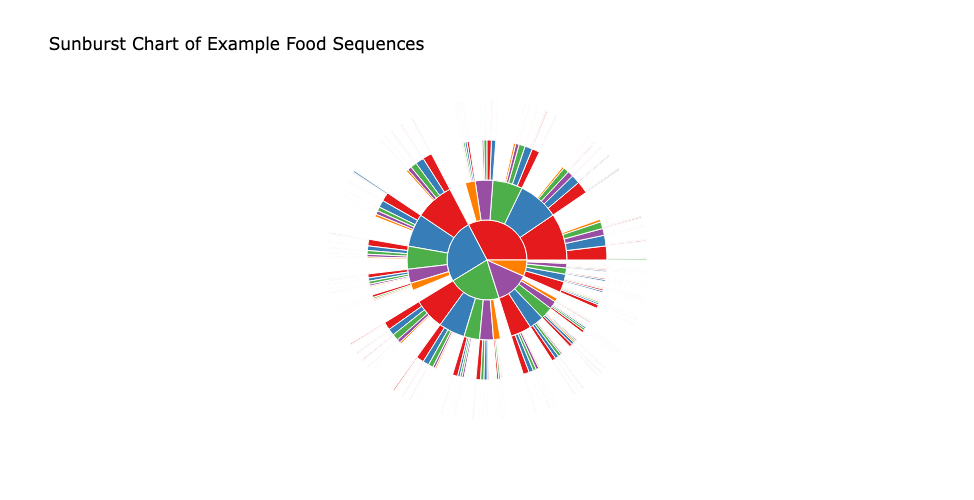

In [41]:
# Create the sunburst figure
buffet_fig = go.Figure(go.Sunburst(
    ids=sunburst_df['id'],
    labels=sunburst_df['label'],
    parents=sunburst_df['parent'],
    values=sunburst_df['value'],
    marker_colors=sunburst_df['color'], # Use the new color column
    insidetextorientation='radial',
    domain={'x': [0, 1], 'y': [0, 1]}
))

buffet_fig.update_layout(
    autosize=False,
    height=500,
    width=500,
    title_text='Sunburst Chart of Example Food Sequences',
    font=dict(
        color="black"
    ),
    uniformtext=dict(minsize=12, mode='hide'),
    paper_bgcolor="White"
)

buffet_fig.show()

# EPA Example

The EPA web log example begins on p. 170 of the textbook. Python can't read the provided RDS file directly, so I created a CSV manually and provide it in the `/data` folder. The code assumes that you ran `jupyter notebook` from the `notebooks` folder of the repository. If you ran it from another folder, fix the paths so that Jupyter can locate the data file.

In [42]:
# Load the web log data from the CSV file
epa_df = pd.read_csv('../data/epa_log.csv')


In [43]:
epa_df['datetime'] = pd.to_datetime(epa_df['datetime'], format='mixed', errors='coerce')
# Order the data by host and datetime
epa_ordered = epa_df.sort_values(by=['host', 'datetime']).copy()

# Get time differences between rows in minutes
epa_ordered['time_diff'] = epa_ordered.groupby('host')['datetime'].diff().dt.total_seconds() / 60

# Determine new sessions based on host change or time cutoff
session_time_cutoff = 15
epa_ordered['new_session'] = (epa_ordered['host'] != epa_ordered['host'].shift(1)) | \
                             (epa_ordered['time_diff'] >= session_time_cutoff)
epa_ordered.loc[0, 'new_session'] = True
epa_ordered['session'] = epa_ordered['new_session'].cumsum()

The time cutoff that marks a new session is a decision we make as analysts. What happens if we change the cutoff?

In [44]:
def analyze_sessions(cutoff):
    """
    Analyzes and prints session statistics for a given time cutoff.
    """
    # Make a copy of the DataFrame to avoid permanent changes
    epa_ordered_temp = epa_ordered.copy()

    # Recalculate 'new_session' based on the interactive cutoff value
    epa_ordered_temp['new_session'] = (epa_ordered_temp['host'] != epa_ordered_temp['host'].shift(1)) | \
                                     (epa_ordered_temp['time_diff'] >= cutoff)

    # Ensure the first row is always a new session
    epa_ordered_temp.loc[0, 'new_session'] = True

    # Recalculate 'session' using cumsum
    epa_ordered_temp['session'] = epa_ordered_temp['new_session'].cumsum()

    # Count the total number of unique sessions
    total_sessions = epa_ordered_temp['session'].nunique()

    # Calculate pages per session
    pages_per_session = epa_ordered_temp.groupby('session').size()
    avg_pages = pages_per_session.mean()

    # Print the results
    print(f"When session_time_cutoff = {cutoff} minutes:")
    print(f"- Total number of sessions: {total_sessions}")
    print(f"- Average pages per session: {avg_pages:.2f}")

# Create an interactive slider that calls the analyze_sessions function
# The slider ranges from 1 to 60 minutes in steps of 1, with a default value of 15
interact(analyze_sessions, cutoff=widgets.IntSlider(min=1, max=60, step=1, value=15));

interactive(children=(IntSlider(value=15, description='cutoff', max=60, min=1), Output()), _dom_classes=('widg…

In [45]:
# Filter for HTML pages and prepare for sunburst processing
epa_html = epa_ordered[epa_ordered['pagetype'] == 'html'].copy()
epa_html['page'] = epa_html['page'].str.replace('-', '_')

def create_sequence(pages):
    return '-'.join(pages.head(5))

In [54]:
# Group by session and create sequences
epa_sequences = epa_html.groupby('session')['page'].apply(create_sequence).reset_index()
epa_sequences.columns = ['session', 'sequence']

# Get frequency of each sequence
epa_sequences_freq = epa_sequences['sequence'].value_counts().reset_index()
epa_sequences_freq.columns = ['path', 'count']

# show some random rows from the df
random_rows = epa_sequences_freq.sample(n=5)
print(random_rows)

                                                  path  count
373                        /Access/chapter5/s4_10.html      1
820  /Press.html-/docs/PressReleases/1995/August/Da...      1
261  /GCDOAR/airrad/airrad.html-/docs/browner/admin...      1
663          /docs/chemfact/chemical/s_perchl.txt.html      1
823                    /Rules.html-/docs/feedback.html      1


In [53]:
# Filter for sequences with more than one occurrence
epa_sequences_freq_filtered = epa_sequences_freq[epa_sequences_freq['count'] > 1].copy()
print(epa_sequences_freq_filtered.head(5))

                    path  count
0            /Rules.html     53
1         /docs/CSO.html     50
2    /docs/Internet.html     45
3  /docs/Government.html     33
4             /Info.html     33


## Sunburst

Before we plot this data, we need to build the hierarchy and set some colors.



In [ ]:
# Create a color map for the unique pages
unique_pages = pd.Series(epa_sequences_freq_filtered['path'].str.split('-')).explode().unique()
colors = px.colors.qualitative.Plotly
color_map = {page: colors[i % len(colors)] for i, page in enumerate(unique_pages)}

In [47]:
def build_epa_sunburst_data(df):
    node_data = []
    added_nodes = set()

    for _, row in df.iterrows():
        path = row['path']
        value = row['count']
        nodes = path.split('-')

        for i in range(1, len(nodes) + 1):
            current_path = ' --> '.join(nodes[:i])
            parent_path = ' --> '.join(nodes[:i-1]) if i > 1 else ''

            if current_path not in added_nodes:
                label = nodes[i-1]
                color = color_map.get(label, '#CCCCCC')
                node_data.append({
                    'id': current_path,
                    'parent': parent_path,
                    'label': label,
                    'value': 0,
                    'color': color
                })
                added_nodes.add(current_path)

            if i == len(nodes):
                for node in node_data:
                    if node['id'] == current_path:
                        node['value'] = value
                        break

    return pd.DataFrame(node_data)

sunburst_df_epa = build_epa_sunburst_data(epa_sequences_freq_filtered)

In [55]:
# Create the Sunburst Plot
epa_fig = go.Figure(go.Sunburst(
    ids=sunburst_df_epa['id'],
    labels=sunburst_df_epa['label'],
    parents=sunburst_df_epa['parent'],
    values=sunburst_df_epa['value'],
    marker_colors=sunburst_df_epa['color'],
    insidetextorientation='radial',
    domain={'x': [0, 1], 'y': [0, 1]},
    hovertemplate='<b>Full Sequence:</b><br>'
                  ' %{id}<br>'
                  '<b>Count:</b> %{value}'
))

epa_fig.update_layout(
    autosize=False,
    height=500,
    width=500,
    title_text='EPA Web Log Sunburst Chart',
    font=dict(
        color="black"
    ),
    uniformtext=dict(minsize=12, mode='hide'),
    paper_bgcolor="White"
)

epa_fig.show()